In [34]:
# %pip install transformers==4.30.1 torchmetrics onnx onnxruntime

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 37.4 MB/s eta 0:00:0000:010:02
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [17]:
import os
import torch
import torch.nn as nn
import albumentations as A
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import BeitForImageClassification
from torch.optim import AdamW
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, f1_score

from torch.cuda.amp import autocast, GradScaler
from transformers import BeitImageProcessor
import requests
from tqdm import tqdm

from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

In [3]:
torch.__version__

'2.0.1+cu118'

In [4]:
train_path = "split_dataset/train"
val_path = "split_dataset/val"
test_path = "split_dataset/test"

In [5]:
# Конфигурация
config = {
    "model_name": "microsoft/beit-large-patch16-224-pt22k-ft22k",
    "img_size": 224,
    "batch_size": 32,
    "epochs": 10,
    "lr": 3e-5,
    "num_workers": 4,
    "num_classes": 144,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

In [6]:
# Аугментации с Albumentations
train_transform = A.Compose([
    A.Resize(config['img_size'], config['img_size']),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=20, p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # BEiT-specific normalization
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(config['img_size'], config['img_size']),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(config['img_size'], config['img_size']),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

In [7]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.get_class = {i: cls for i, cls in enumerate(self.classes)}
        self.samples = []
        self.transform = transform

        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                self.samples.append((
                    os.path.join(cls_dir, img_name),
                    self.class_to_idx[cls]
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = np.array(Image.open(img_path).convert("RGB"))

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        return image, torch.tensor(label, dtype=torch.long)

In [8]:
# Инициализация данных
train_dataset = CustomDataset(
    train_path,
    transform=train_transform
)
val_dataset = CustomDataset(
    val_path,
    transform=val_transform
)
test_dataset = CustomDataset(
    test_path,
    transform=test_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers'],
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=True
)

In [10]:
model = BeitForImageClassification.from_pretrained(
    config['model_name'],
    num_labels=len(train_dataset.classes),
    ignore_mismatched_sizes=True
).to(config["device"])
# model = torch.compile(model)

/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-large-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1024]) in the checkpoint and torch.Size([144, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([144]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
optimizer = AdamW(model.parameters(), lr=config['lr'])

In [12]:
def train_model(model, train_loader, val_loader, optimizer, config):
    device = config['device']
    epochs = config['epochs']
    scaler = GradScaler()

    num_classes = config['num_classes']  # обязательно передай число классов в config
    
    train_acc_metric = MulticlassAccuracy(num_classes=num_classes, average='weighted').to(device)
    train_f1_metric = MulticlassF1Score(num_classes=num_classes, average='weighted').to(device)

    val_acc_metric = MulticlassAccuracy(num_classes=num_classes, average='weighted').to(device)
    val_f1_metric = MulticlassF1Score(num_classes=num_classes, average='weighted').to(device)

    history = {'train_loss': [], 'val_loss': [],
               'train_acc': [], 'val_acc': [],
               'train_f1': [], 'val_f1': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc_metric.reset()
        train_f1_metric.reset()

        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs} [Train]") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                with autocast():
                    outputs = model(pixel_values=images, labels=labels)
                    loss = outputs.loss
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                train_loss += loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                
                train_acc_metric.update(preds, labels)
                train_f1_metric.update(preds, labels)

                tepoch.set_postfix({'loss': loss.item()})

        train_loss /= len(train_loader)
        train_acc = train_acc_metric.compute().item()
        train_f1 = train_f1_metric.compute().item()

        # Валидация
        model.eval()
        val_loss = 0
        val_acc_metric.reset()
        val_f1_metric.reset()

        with torch.no_grad(), tqdm(val_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs} [Val]") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)

                outputs = model(pixel_values=images, labels=labels)
                val_loss += outputs.loss.item()
                preds = torch.argmax(outputs.logits, dim=1)

                val_acc_metric.update(preds, labels)
                val_f1_metric.update(preds, labels)

                tepoch.set_postfix({'val_loss': outputs.loss.item()})

        val_loss /= len(val_loader)
        val_acc = val_acc_metric.compute().item()
        val_f1 = val_f1_metric.compute().item()

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

    return history

In [21]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(18, 5))

    # 1. Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # 2. Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    # 3. F1-score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_f1'], label='Train F1')
    plt.plot(epochs, history['val_f1'], label='Val F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.title('F1-score per Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("beit_history.png")
    plt.show()

In [ ]:
history = train_model(model, train_loader, val_loader, optimizer, config)

Epoch 10/10 [Val]: 100%|██████████| 1494/1494 [15:12<00:00,  1.64batch/s, val_loss=7.12] 


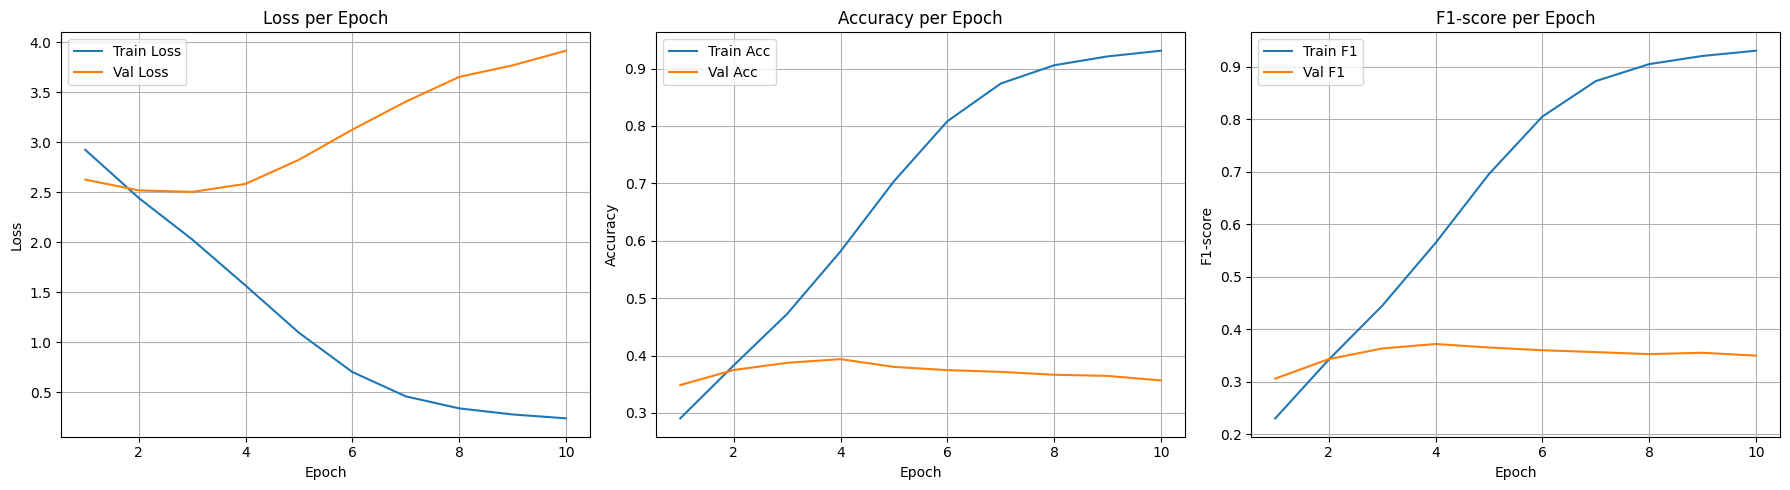

In [22]:
plot_training_history(history)

Сохранение модели

In [33]:
model.eval().cpu()
dummy_input = torch.randn(1, 3, 224, 224)
torch.onnx.export(
    model,
    dummy_input,
    "models/beit_model.onnx",
    input_names=["pixel_values"],
    output_names=["logits"],
    dynamic_axes={"pixel_values": {0: "batch_size"}, "logits": {0: "batch_size"}},
    opset_version=11
)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

